# Run models

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/ModelsImplementation.ipynb

%run Mappings.ipynb
%run ModelsImplementation.ipynb

In [3]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
# RESULTS_DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/results/'
DIR = ''
RESULTS_DIR = 'results/'

### Functions for strategies and balance transformation

In [4]:
def get_strategy_data(strategy=None):
    X_train = None
    y_train = None
    if strategy=='strategy1':
        X_train = data_dropped.drop(columns=['Que16']).to_numpy()
        y_train = data_dropped['Que16'].to_numpy()
    elif strategy=='strategy2':
        X_train = data_median.drop(columns=['Que16']).to_numpy()
        y_train = data_median['Que16'].to_numpy()
    elif strategy=='strategy3':
        X_train = data_mean.drop(columns=['Que16']).to_numpy()
        y_train = data_mean['Que16'].to_numpy()
    elif strategy=='strategy4':
        X_train = data_most_frequent.drop(columns=['Que16']).to_numpy()
        y_train = data_most_frequent['Que16'].to_numpy()
    else:
        X_train = None
        y_train = None
    return X_train, y_train

def get_balanced_data(X_train, y_train, balance=None, X_val=None, y_val=None):
    X_balanced = None
    y_balanced = None
    train_val_indices = None
    if balance=='no_balance':
        X_balanced = X_train
        y_balanced = y_train
    elif balance=='under':
        rus = RandomUnderSampler(random_state=0)
        X_balanced, y_balanced = rus.fit_resample(X_train, y_train)
    elif balance=='over':
        ros = RandomOverSampler(random_state=0)
        X_balanced, y_balanced = ros.fit_resample(X_train, y_train)
    elif balance=='smoteenn':
        smote_enn = SMOTEENN(random_state=0)
        X_balanced, y_balanced = smote_enn.fit_resample(X_train, y_train)
    else:
        X_balanced = None
        y_balanced = None
        
    if X_val is not None and y_val is not None:
        ind_train = [ind for ind in range(0, len(X_balanced))]
        ind_val = [ind for ind in range(len(X_balanced), len(X_balanced)+len(X_val))]
        X_balanced = np.append(X_balanced, X_val, axis=0)
        y_balanced = np.append(y_balanced, y_val, axis=0)
        train_val_indices = [[ind_train, ind_val]]
        
    return X_balanced, y_balanced, train_val_indices

def get_data_frames(data_train):
    #strategy 1
    data_dropped = data_train.dropna().reset_index(drop=True)
    data_dropped = perform_mapping(data_dropped, questions_map_EN)
    #strategy 2
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    data_median = pd.DataFrame(imputer.fit_transform(data_train))
    data_median.columns = data_train.columns
    data_median.index = data_train.index
    data_median = perform_mapping(data_median, questions_map_EN)
    #strategy 3
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    data_mean = pd.DataFrame(imputer.fit_transform(data_train))
    data_mean.columns = data_train.columns
    data_mean.index = data_train.index
    # mean values are not integer numbers so rounding to int was necessary
    data_mean = data_mean.round()
    data_mean = perform_mapping(data_mean, questions_map_EN)
    #strategy 4
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data_most_frequent = pd.DataFrame(imputer.fit_transform(data_train))
    data_most_frequent.columns = data_train.columns
    data_most_frequent.index = data_train.index
    data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)
    
    return data_dropped, data_median, data_mean, data_most_frequent

# Cross validation

## Data preparation 

In [5]:
data_train = pd.read_csv(DIR+'dataset/train_test/train_data.csv')
data_test = pd.read_csv(DIR+'dataset/train_test/test_data.csv')

In [6]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

In [7]:
data_test_mapped = perform_mapping(data_test, questions_map_EN)
X_test = data_test.drop(columns=['Que16']).to_numpy()
y_test = data_test['Que16'].to_numpy()
data_dropped, data_median, data_mean, data_most_frequent = get_data_frames(data_train)

## Run

In [9]:
result_cols = ['strategy', 'model', 'balance', 'val_score', 'recall', 'accuracy', 'precision', 'roc_auc', 'f1-score', 'conf matrix', 'time', 'params']
key = 0
dict_metric = {}
strategies = ['strategy1', 'strategy2', 'strategy3', 'strategy4']
models = ['log_reg', 'dec_tree', 'rand_for']
balances = ['no_balance', 'under', 'over', 'smoteenn']
for strategy in strategies:
    for model in models:
        for balance in balances:
            title = strategy + ' ' + model + ' ' + balance
            print(title)
            dict_metric[key] = []
            dict_metric[key].extend([strategy, model, balance])
            X_train, y_train = get_strategy_data(strategy)
            X_train, y_train, _ = get_balanced_data(X_train, y_train, balance)
            
            try:
                if model=='log_reg':
                    metrics = perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='dec_tree':
                    metrics = perform_decision_tree(X_train, y_train, X_test, y_test)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='rand_for':
                    metrics = perform_random_forest(X_train, y_train, X_test, y_test, title)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                else:
                    print('Not existing model!')
                key+=1
            except:
                dict_metric[key].extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                key+=1
                continue
result_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=result_cols)
result_df.to_csv(RESULTS_DIR+'results_cross_val_'+str(time.time())+'.csv', index=False)

strategy1 dec_tree no_balance
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy1 dec_tree under
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy1 dec_tree over
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy1 dec_tree smoteenn
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy2 dec_tree no_balance
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy2 dec_tree under
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy2 dec_tree over
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy2 dec_tree smoteenn
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy3 dec_tree no_balance
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy3 dec_tree under
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
strategy3 dec_tree over
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
str

# Validation

In [28]:
data_train = pd.read_csv(DIR+'dataset/train_val_test/train_data.csv')
data_val = pd.read_csv(DIR+'dataset/train_val_test/val_data.csv')
data_test = pd.read_csv(DIR+'dataset/train_val_test/test_data.csv')

In [29]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Data preparation

In [30]:
data_test_mapped = perform_mapping(data_test, questions_map_EN)
X_test = data_test.drop(columns=['Que16']).to_numpy()
y_test = data_test['Que16'].to_numpy()
data_val_mapped = perform_mapping(data_val, questions_map_EN)
X_val = data_val.drop(columns=['Que16']).to_numpy()
y_val = data_val['Que16'].to_numpy()
data_dropped, data_median, data_mean, data_most_frequent = get_data_frames(data_train)

## Run

strategy1 rand_for no_balance
Fitting 1 folds for each of 2970 candidates, totalling 2970 fits
Elapsed time to compute the importances: 0.005 seconds


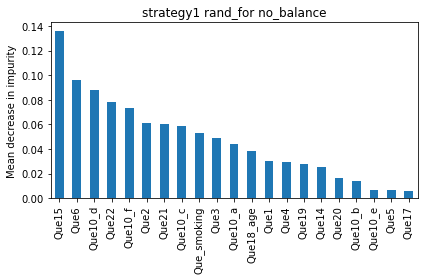

In [31]:
result_cols = ['strategy', 'model', 'balance', 'val_score', 'recall', 'accuracy', 'precision', 'roc_auc', 'f1-score', 'conf matrix', 'time', 'params']
key = 0
dict_metric = {}
strategies = ['strategy1', 'strategy2', 'strategy3', 'strategy4']
models = ['log_reg', 'dec_tree', 'rand_for']
balances = ['no_balance', 'under', 'over', 'smoteenn']
for strategy in strategies:
    for model in models:
        for balance in balances:
            title = strategy + ' ' + model + ' ' + balance
            print(title)
            dict_metric[key] = []
            dict_metric[key].extend([strategy, model, balance])
            X_train, y_train = get_strategy_data(strategy)
            X_train, y_train, train_val_indices = get_balanced_data(X_train, y_train, balance, X_val, y_val)
            
            try:
                if model=='log_reg':
                    metrics = perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col, train_val_indices)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='dec_tree':
                    metrics = perform_decision_tree(X_train, y_train, X_test, y_test, train_val_indices)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                elif model=='rand_for':
                    metrics = perform_random_forest(X_train, y_train, X_test, y_test, title, train_val_indices)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5], metrics[2], metrics[3]])
                else:
                    print('Not existing model!')
                key+=1
            except:
                dict_metric[key].extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                key+=1
                continue
result_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=result_cols)
result_df.to_csv(RESULTS_DIR+'results_val_'+str(time.time())+'.csv', index=False)